In [1]:
%matplotlib inline
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import IPython
import sklearn
from IPython.display import display
import mglearn

print(f'Python version: {sys.version}')
print(f'pandas version: {pd.__version__}')
print(f'matplotlib version: {matplotlib.__version__}')
print(f'NumPy version: {np.__version__}')
print(f'SciPy version: {sp.__version__}')
print(f'IPython version: {IPython.__version__}')
print(f'scikit-learn version: {sklearn.__version__}')

/Users/matthewmckenna/miniconda3/envs/intro-to-ml/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


Python version: 3.7.0 (default, Jun 28 2018, 07:39:16) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
pandas version: 0.23.4
matplotlib version: 2.2.3
NumPy version: 1.15.1
SciPy version: 1.1.0
IPython version: 6.4.0
scikit-learn version: 0.19.1


# Ensembles of decision trees

*Ensembles* combine multiple machine learning models to create more powerful models.
Two such ensembles have proved to be effective on a wide range of datasets for classification and regression: random forests, and gradient boosted decision trees.

## Random forests

Decision trees tend to overfit.
A random forest is a collection of decision trees, where each tree is slightly different from the others.
The idea is that each tree might do a relatively good job at predicting, but will likely overfit on part of the data.
With many trees, they will work well and overfit in different ways, yet the overfitting can be reduced by averaging their results.

Random forests get their name by injecting randomness into the tree building, to ensure each tree is different.
This can be done in two ways: by selecting data points used to build a tree, and by selecting the features in each split test.

### Building random forests

You must first decide on the number of trees to build (`n_estimators` parameter of `RandomForestRegressor` or `RandomForestClassifier`).
Say we wish to build 10 trees.

To build a tree we first take a *bootstrap sample* of our data.
From the `n_samples` data points, we repeatedly draw an example randomly with replacement, `n_samples` times.
This creates a dataset as big as the original, but some data points will be missing (approximately one third), and some will be repeated.

Say we wanted to create a bootstrap sample of the list `['a', 'b', 'c', 'd']`.
One possible sample would be `['b', 'd', 'd', 'c']` and other could be `['d', 'a', 'd', 'a']`.

A decision tree is then built on this new dataset.
The decision tree algorithm is slightly modified however.
Instead of looking for the best test in each node, the algorithm randomly selects a subset of features, and looks for the best possible test involving one of these features.
The number of features selected is controlled by `max_features`.
The selection of the subset of features is repeated separately in each node, so that each node in a tree can make a decision using a different subset of features.

`max_features` is a critical parameter.
If we set `max_features` to `n_features` that means each split can look at all features in the dataset, and no randomness will be injected in the feature selection.
If we set `max_features` to `1`, that means all the splits have no choice on which feature to test, and can only search over different thresholds.

A high `max_features` means that the trees in the random forest will be quite similar, and they will be able to fit the training data easily, using the most distinctive features.
A low `max_features` means that the trees in the random forest will be quite different, and that each tree might need to be very deep in order to fit the data well.

To make a prediction, the algorithm first makes a prediction for every tree in the forest.
For regression, we average results to get a final prediction.
For classification a "soft voting" strategy is used.

### Analysing random forests

We build a random forest consisting of five trees to the `two_moons` dataset.

In [2]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

/Users/matthewmckenna/miniconda3/envs/intro-to-ml/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

The trees are stored in the `estimator_` attribute.

We can visualise the decision boundaries learned by each tree, together with their aggregate prediction as made by the forest:

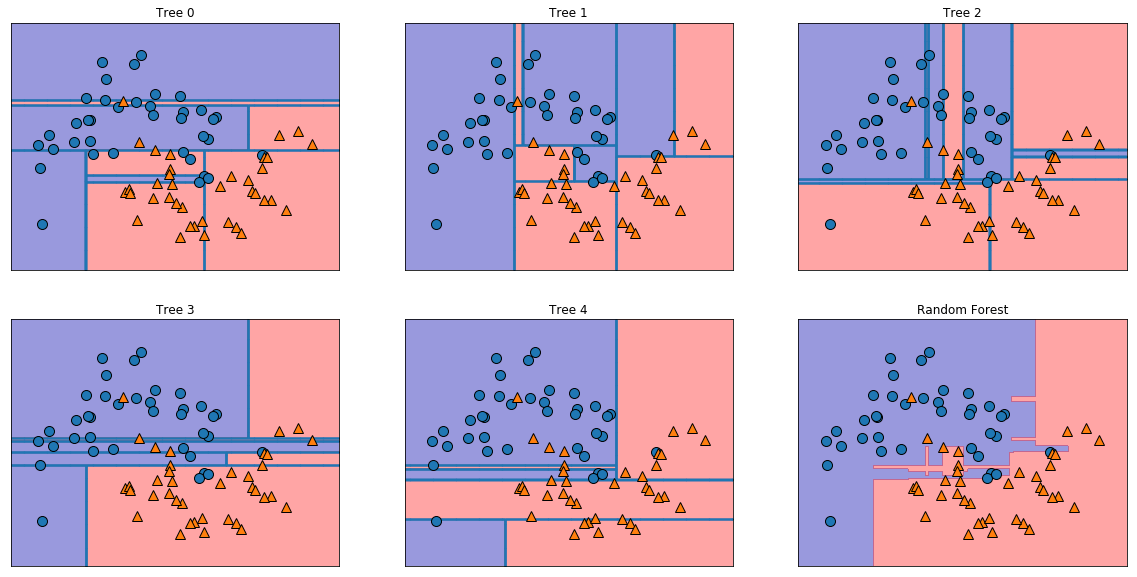

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title(f'Tree {i}')
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)

mglearn.plots.plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, -1], alpha=0.4)
axes[-1, -1].set_title('Random Forest')
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

We see that the boundaries learned by the five trees are quite different.
Each make some mistakes, as some of the training points that are plotted were not included in the training set of the trees, due to the bootstrap sampling.

The random forest overfits less than any of the trees individually, and provides a much more intuitive decision boundary.

In real applications we would use hundreds or thousands of trees, leading to even smoother boundaries.
As another example, let's apply a random forest with 100 trees to the Breast Cancer example

In [4]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data,
    cancer.target,
    random_state=0,
)
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print(f'Accuracy on training set: {forest.score(X_train, y_train):.3f}')
print(f'Accuracy on test set: {forest.score(X_test, y_test):.3f}')

Accuracy on training set: 1.000
Accuracy on test set: 0.972


The random forest gives an accuracy of 97%, better than the linear models or single decision tree without tuning any parameters.
We could adjust `max_features` or apply pre-pruning, however, often the default parameters of the random forest already work quite well.

Feature importances are also provided by random forests.
They're computed by aggregating the feature importances over the trees in the forest.

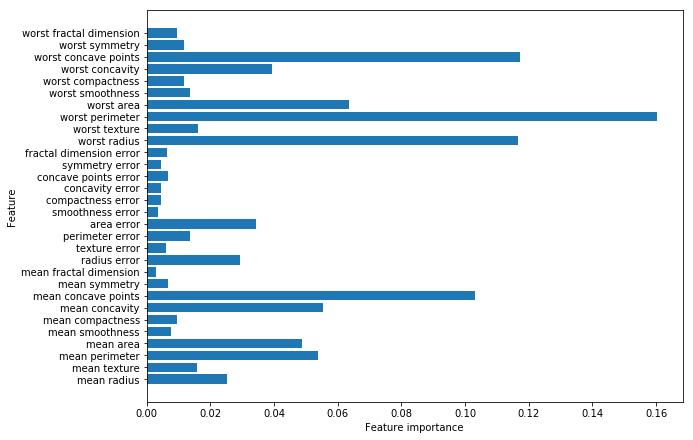

In [5]:
def plot_feature_importances_cancer(model):
    plt.figure(figsize=(9.6, 7.2))
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')


plot_feature_importances_cancer(forest)

### Strenghts, weaknesses, and parameters

Random forests are among the most widely used machine learning methods.
They are very powerful and often work well without heavy tuning of the parameters, and don't require scaling of the data.

Random forests share all of the benefits of decision trees, while making up for some deficiencies.
A reason to still prefer a single tree is if you need a compact representation of the decision-making process.
It's basically impossible to interpret tens or hundreds of trees in detail.

While building random forests on large datasets can be time consuming, it can be parallelised across multiple CPUs.
You can use the `n_jobs` parameter to adjust the number of cores to use.
More CPUs will result in a linear speed-up up to the number of cores available.
Set `n_jobs=-1` to use all cores in the computer.

Setting different random states can drastically change the model that is built.
The more trees the more robust it will be against the choice of `random_state`.

Weaknesses:

* don't tend to perform well on very high dimensional, sparse data such as text.
  * linear models may be more appropriate for this data
* require more memory
* slower to train and predict than linear models

Strengths:

* work well on very large datasets
* training can easily be parallelised

ParametersL

* `n_estimators`
  * larger always better
  * averaging more trees will yield a more robust ensemble by reducing overfitting
  * "build as many as you have time for"
* `max_features`
  * smaller value reduces overfitting
  * good rule of thumb:
    * `sqrt(num_features)` for classification
    * `num_features` for regression
* `max_depth` possibly